In [1]:
import googlemaps
import networkx as nx
import folium
import numpy as np
import matplotlib.pyplot as plt

In [70]:
class NoName:
    """
    1. Receive the shortest distance by receiving the source and target
    2. Receive point value or derive route information around it
    3. Derivation of slope by receiving source and target
    """
    
    def __init__(self,source,target,point=None):
        assert type(source) is str or tuple, 'source type must be location name or lonlat'
        assert type(target) is str or tuple, 'target type must be location name or lonlat'
        
        self.source = source
        self.target = target
        self.point = point
        self.gmaps_key = "your googlemaps key"
        self.gmaps = googlemaps.Client(key=self.gmaps_key)
        self.G = nx.read_gpickle('road_network.gpickle')
        if type(source)==str:self.source=self.get_geocode(source)
        if type(target)==str:self.target=self.get_geocode(target)
        if point == None:self.point = source
    
    def get_geocode(self,place):
        """
        input :: place name (str)
        output :: place geocode (tuple)
        """
        
        gmaps = googlemaps.Client(key=self.gmaps_key)
        result = gmaps.geocode(place)
        lat = result[0]['geometry']['location']['lat']
        lon = result[0]['geometry']['location']['lng']
        return lat,lon
    
    def get_nearest_link(self,point):
        """
        input :: place geocode (tuple)
        output :: road nearest to the point (source_id,target_id)
        """
        
        links = self.G.edges
        srt_link_dist = 9999
        for source,target in links:
            middle_point = tuple((x+y)/2 for x,y in zip(self.G.nodes[source]['lonlat'],self.G.nodes[target]['lonlat']))
            dist = sum((x-y)**2 for x,y in zip(point,middle_point))
            if dist<srt_link_dist:
                srt_link_dist = dist
                srt_link = source,target
        return srt_link
    
    def get_elevation(self,source,target,number_of_sample = 100):
        """
        input :: source and target geocode (tuple)
        output :: elevation in source to target (list)
        """
        path_elevation = self.gmaps.elevation_along_path(path = [source,target],samples=number_of_sample)
        elevation = [x['elevation'] for x in path_elevation]
        return elevation
    
    def get_srt_path(self,mapping=True):
        if mapping:
            source_ = self.get_nearest_link(self.source)[0]
            target_ = self.get_nearest_link(self.target)[1]
            
            path = nx.shortest_path(self.G,source_,target_,weight="distance")
            dist = nx.shortest_path_length(self.G,source_,target_,weight="distance")
            
            source_loc = self.G.nodes[path[0]]['lonlat']
            target_loc = self.G.nodes[path[-1]]['lonlat']
            ex_map = folium.Map(location=source_loc,zoom_start= 12)
            folium.Marker(location=source_loc,
                          icon=folium.Icon(color='red',icon='star')
                         ).add_to(ex_map)
            folium.Marker(location=target_loc,
                          icon=folium.Icon(color='red',icon='star')
                         ).add_to(ex_map)
            
            for i in range(len(path)-1):
                folium.PolyLine(locations=[self.G.nodes[path[i]]['lonlat'],self.G.nodes[path[i+1]]['lonlat']],
                                c = "blue").add_to(ex_map)
            print(dist)
            return ex_map
        else:
            source_ = self.get_nearest_link(self.source)[0]
            target_ = self.get_nearest_link(self.target)[1]

            path = nx.shortest_path(self.G,source_,target_,weight="distance")
            dist = nx.shortest_path_length(self.G,source_,target_,weight="distance")
            
            return path,dist
        
        
    def plot_elevation(self,path,dist):
        elevations = []
        temp = []
        for i in range(len(path)-1):
            source_lonlat = self.G.nodes[path[i]]['lonlat']
            target_lonlat = self.G.nodes[path[i+1]]['lonlat']
            temp_dist = self.G.edges[(path[i],path[i+1])]['distance']
            ratio = temp_dist/dist
            n_samples = int(512*ratio)
            
            elevation = self.get_elevation(source_lonlat,target_lonlat,number_of_sample=n_samples)
            elevations+=elevation
            temp.append(n_samples)
        plt.figure(figsize=(40,20))
        plt.bar(range(len(elevations)),elevations)
        x = 0
        for i in temp:
            x += i
            plt.axvline(x,color='r', linewidth=5, ymin=0,ymax=elevations[x-1]/max(elevations)*0.95)
        return plt.show()

In [79]:
sample = NoName('인하대학교','한국가스공사 인천기지본부')

In [82]:
sample.source

(37.4500221, 126.653488)

In [80]:
sample.get_srt_path()

6374.342300000001


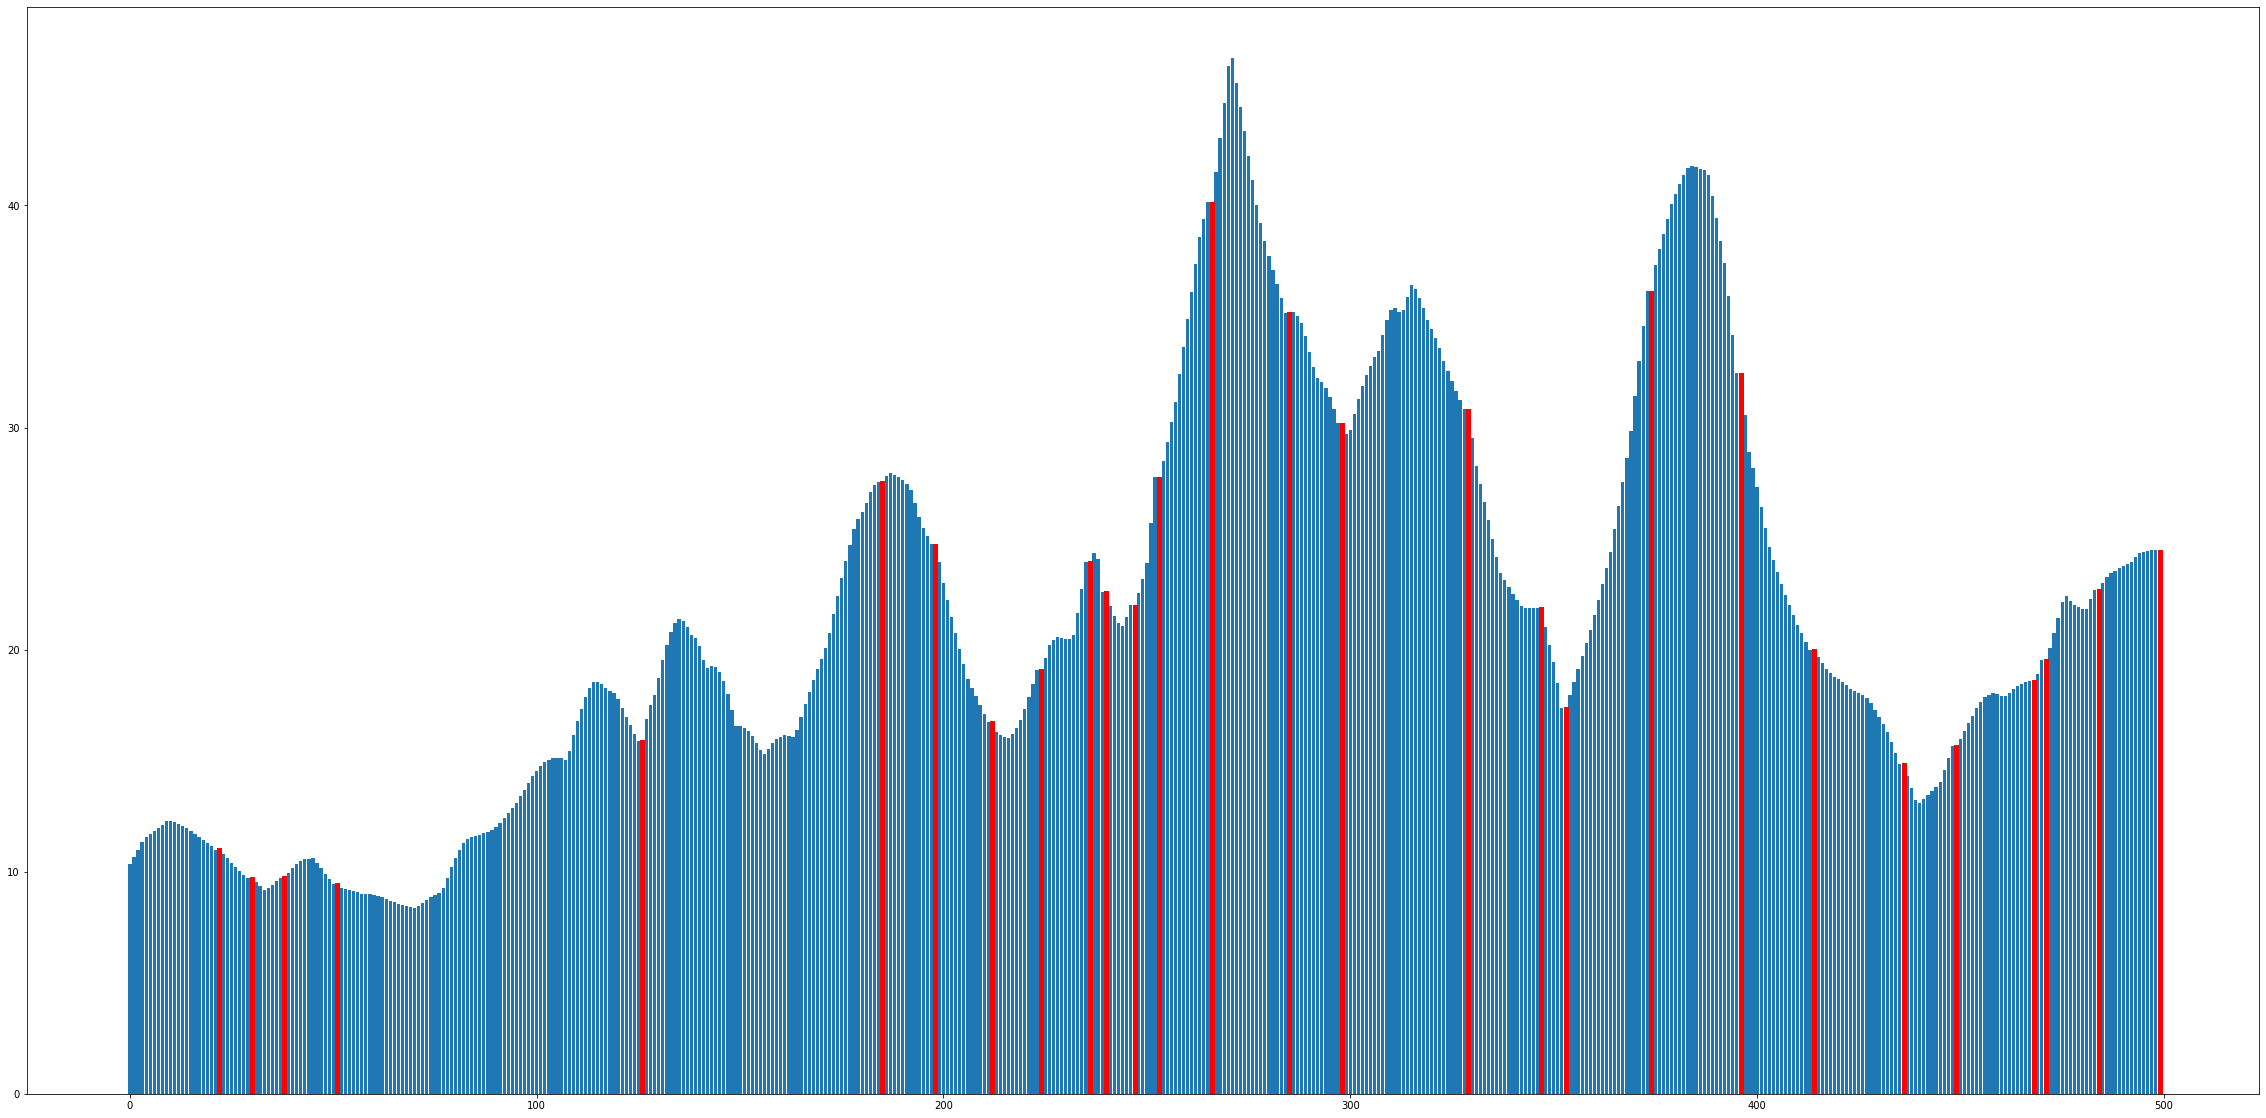

In [81]:
sample.plot_elevation(*sample.get_srt_path(mapping=False))